<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/data/notebooks/Dataset-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select your Dataset

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Shape Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 1

# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
# 0 = airplane
# 1 = automobile
# 2 = bird
# 3 = cat
# 4 = deer										
# 5 = dog
# 6 = frog
# 7 = horse
# 8 = ship
# 9 = truck
CIFAR10_CLASS = 2

# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "paraglider"

# Library Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.stats import norm
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
from sklearn.manifold import TSNE
from skimage import io
from skimage.transform import resize

# Dataset Setup

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'


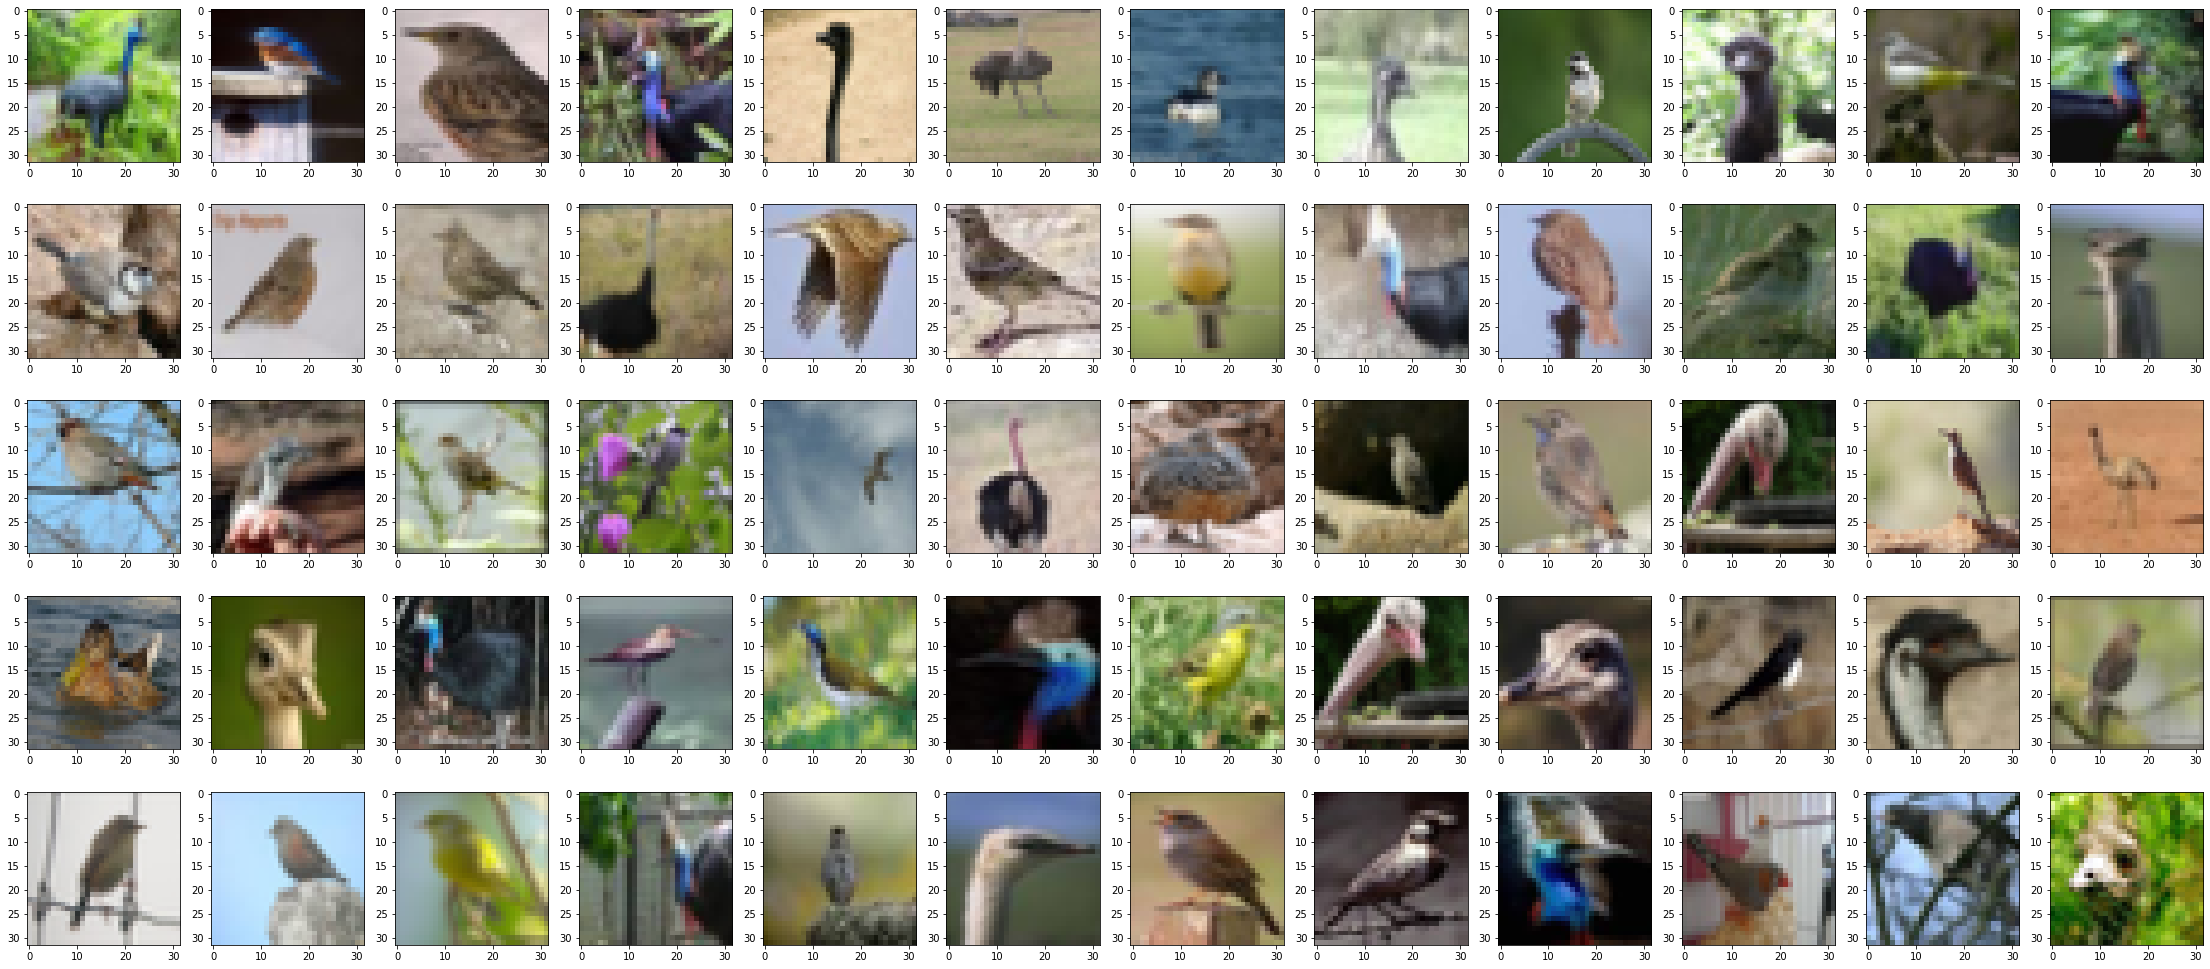

In [8]:
# Initialise empty repository to pull data into
!git init 
# Add the remote origin
!git remote add origin -f https://github.com/conwayjw97/Image-Colourisation-with-Deep-Learning.git
# Reset the HEAD in case a different folder was already pulled
!git reset --hard HEAD
!git clean -f -d
# Tell git we are checking out specific folders
!git config core.sparsecheckout true

# Shape Set
if(DATASET_CHOICE == 0):
  # Recursively checkout the dataset folders
  !echo "data/datasets/ShapeSet/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and shuffle
  images = []
  for image in io.imread_collection("data/datasets/ShapeSet/*.jpg"): 
    if(image.shape == (128, 128, 3)):
      images.append(np.array(image))
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  images = np.array(images)[indices]
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  # Scale pixel data to [0,1]
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Image output variables, change these to see different images on the results
  output_count = 9
  index_offset = 0

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(images[i])

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

# Cifar10
elif(DATASET_CHOICE == 1):
  # Load and scale dataset
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Prune dataset to chosen class
  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]
  
  # Output portion of the dataset
  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  # Image output variables, change these to see different images on the results
  output_count = 12
  index_offset = 20

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

# Faces Images
elif(DATASET_CHOICE == 2):
  # Recursively checkout the dataset folders
  !echo "data/datasets/face_images/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  images = train_images = test_images = []
  for image in io.imread_collection("data/datasets/face_images/*.jpg"): 
    images.append(resize(image, (128, 128)))
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 20
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

# Imagenette
elif(DATASET_CHOICE == 3):
  # Recursively checkout the dataset folders
  !echo "data/datasets/imagenette2-160/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and resize dataset
  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection("data/datasets/imagenette2-160/train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection("data/datasets/imagenette2-160/val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 0
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

# Statistics

In [9]:
print("Total images:", train_images.shape[0])
print("Image width:", train_images.shape[1])
print("Image height:", train_images.shape[2])
print("Data type:", train_images.dtype)
print("Average Red: %.2f" % np.mean(train_images[:,:,:,0]))
print("Average Green: %.2f" % np.mean(train_images[:,:,:,1]))
print("Average Blue: %.2f" % np.mean(train_images[:,:,:,2]))

Total images: 5000
Image width: 32
Image height: 32
Data type: float64
Average Red: 0.49
Average Green: 0.49
Average Blue: 0.42


# Colour Histogram

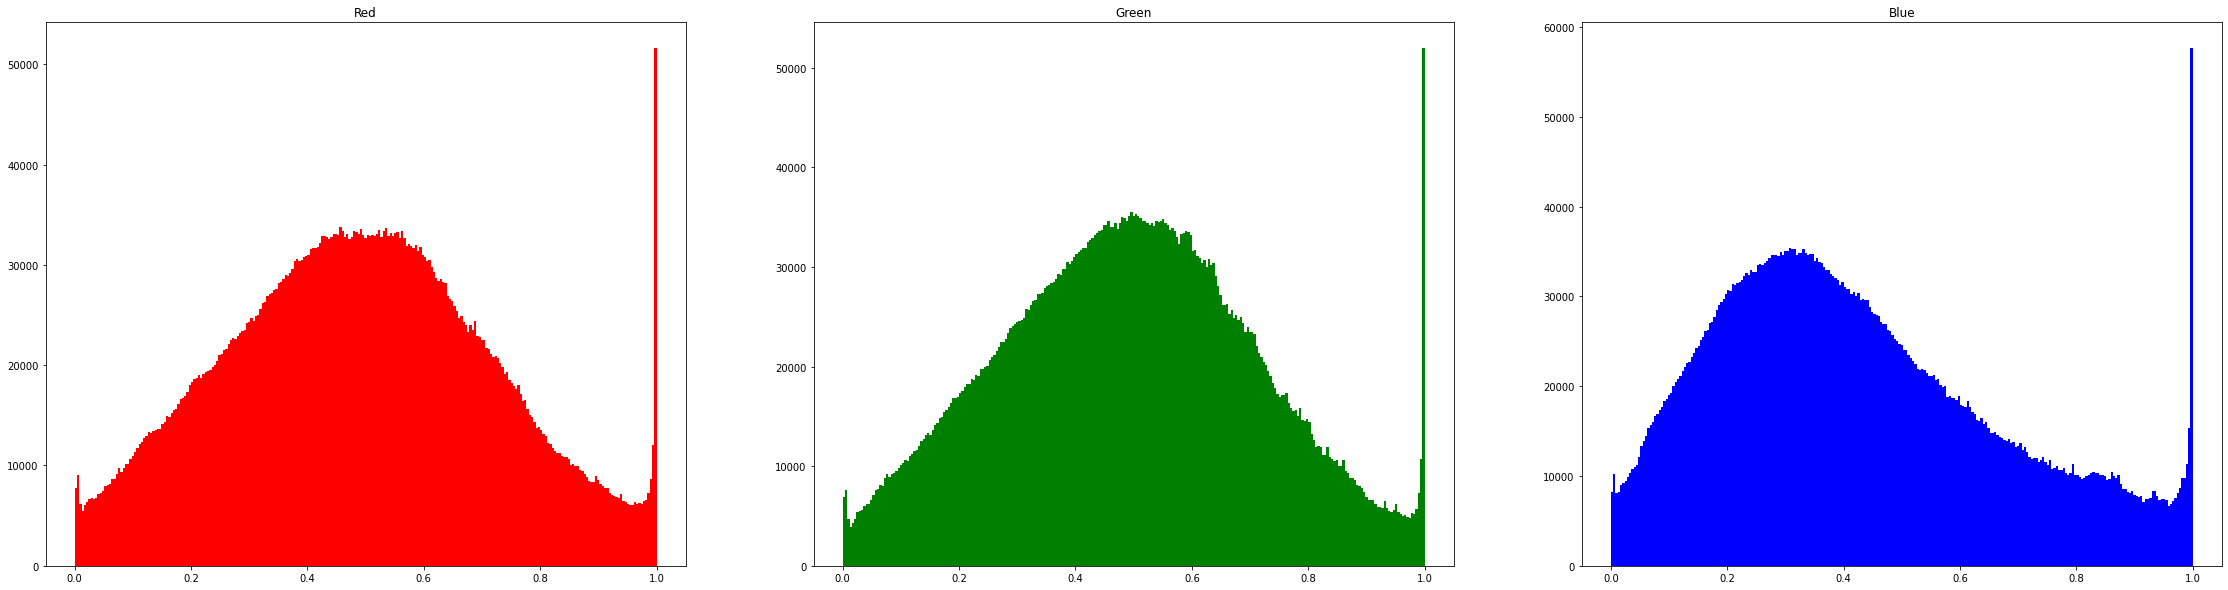

In [10]:
fig = plt.figure(figsize=(39, 10))
count = 0
channels = ("Red", "Green", "Blue")
for i in range(3):
  fig.add_subplot(1,3,i+1)
  plt.title(channels[i])
  plt.hist(train_images[:,:,:,i].flatten(), 255, color=channels[i])